In [24]:
%load_ext autoreload
%autoreload 2
import torch
import configparser
from customDatasetMakers import state_to_dic, ian_dataset
from dataSettings import get_denormalized_dic, get_normalized_dic
from customModels import IanRNN, HiroLRAN, HiroLRANInverse
from train_helpers import get_state_mask, get_sample_time_state_mask, masked_loss
import numpy as np
import matplotlib.pyplot as plt
from prediction_helpers import get_ml_truth, get_ml_profile_warmup, get_ml_actuator_trajectory, get_ml_predictions, get_considered_models, get_fast_profile_prediction
import pickle
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/cakenn_v4_and_scalars.pkl', 'rb') as f:
    scalars = pickle.load(f)
print(scalars.keys())

dict_keys(['times', 'rho', '189649', '193776', '189276', '165301', '150725', '195157', '175552', '187077', '154993', '175176', '177021', '184498', '189510', '161253', '194364', '154769', '184221', '183042', '184204', '173552', '159462', '161608', '199208', '156928', '176390', '144474', '144445', '175355', '189694', '171293', '161362', '150327', '183587', '176346', '190980', '176260', '166733', '159262', '193350', '180530', '167532', '196423', '169930', '176937', '154835', '154957', '162460', '163060', '189069', '190821', '157126', '186419', '177013', '163036', '186509', '166413', '194587', '187315', '168852', '195033', '195129', '176944', '165191', '169850', '173630', '193291', '176251', '194216', '189562', '145108', '194747', '171172', '160918', '154807', '175162', '165532', '165677', '183980', '189619', '189311', '191507', '160675', '190977', '178446', '154843', '193852', '177055', '152443', '169618', '193366', '186548', '163318', '160657', '186547', '175572', '173546', '180472', '18

['144339', '144340', '144341', '144367', '144376', '144380', '144381', '144382', '144383', '144384', '144385', '144410', '144445', '144446', '144448', '144449', '144450', '144451', '144452', '144453', '144454', '144455', '144456', '144457', '144462', '144463', '144465', '144466', '144467', '144468', '144469', '144470', '144471', '144472', '144473', '144474', '144475', '144476', '144477', '144478', '144479', '144480', '144481', '144482', '144483', '144484', '144485', '144486', '144487', '144488', '144489', '144490', '144491', '144492', '144513', '144522', '144523', '144524', '144525', '144528', '144533', '144536', '144548', '144549', '144550', '144551', '144552', '144553', '144687', '144688', '144690', '144696', '144698', '144699', '144700', '144770', '144771', '144781', '144782', '144786', '144787', '144788', '144789', '144790', '144791', '144792', '144793', '144794', '144795', '144796', '144801', '144802', '144803', '144806', '144819', '144820', '144821', '144822', '144825', '144826',

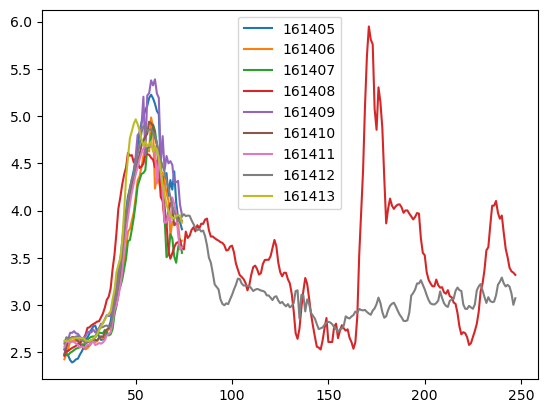

In [23]:
print(list(np.sort(list(scalars.keys()))))
print(scalars['161414'].keys())
# we have data for 
for i in range(161405, 161414):
    plt.plot(scalars[str(i)]['ne'][:, 50], label=str(i))
plt.legend()
    


In [41]:
plt.rcParams.update({
    'font.size': 14,        # Global font size
    'axes.titlesize': 16,   # Font size of the axes title
    'axes.labelsize': 14,   # Font size of the x and y labels
    'xtick.labelsize': 12,  # Font size of the x tick labels
    'ytick.labelsize': 12,  # Font size of the y tick labels
    'legend.fontsize': 12,  # Font size of the legend
    'figure.titlesize': 16  # Font size of the figure title
})

LOAD MODEL

Using /projects/EKOLEMEN/profile_predictor/joe_hiro_models/IanRNN_v8.tar
[0.32771251001588414, 0.023342085935922192, 0.01202333320816335, 0.009468061846148755, 0.008308037340347033, 0.007726764357283986, 0.007015166392019834, 0.006511401128096824, 0.006230699028422807, 0.005961232601819465, 0.005733399294597882, 0.005709314510743413, 0.005481631981427803, 0.005513246223107324, 0.0053375883772540066, 0.005295306743629071, 0.0053926819334051265, 0.005068428813981982, 0.005103348814753584, 0.005020258082763597, 0.005049072154357703, 0.0049386316619347784, 0.004913108932870453, 0.0048385537457212476, 0.004943120990094432, 0.004758577162511475, 0.0047415147800522126, 0.00473788444152368, 0.004659192379127355, 0.004652694138469741, 0.0046579456212715795, 0.004623032308774807, 0.004584060395501279, 0.004577306931873801, 0.004529800721522515, 0.004590979845221219, 0.004494659815810853, 0.004495402785771299, 0.004504786536885074, 0.004434868803919478, 0.004406736042213193, 0.004443222896168051,

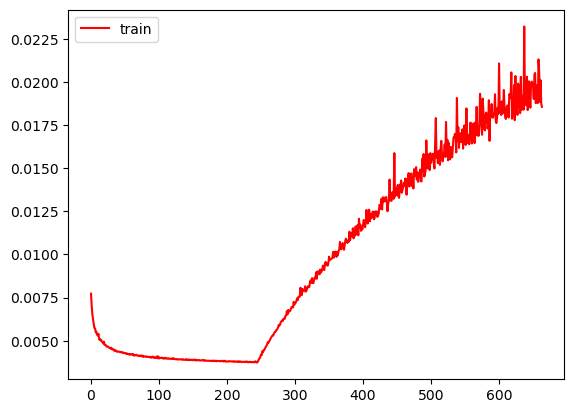

KeyError: 'controllability_losses'

In [27]:
model_name = 'HiroLRAN_v23'
model_name = 'IanRNN_v8'
#model_name = 'HiroLRANDiag_Te_pcs'
config_filename = f'/projects/EKOLEMEN/profile_predictor/joe_hiro_models/{model_name}config'
config=configparser.ConfigParser()
config.read(config_filename)
output_filename_base=config['model']['output_filename_base']
output_dir=config['model']['output_dir']
model_type=config['model']['model_type']
profiles=config['inputs']['profiles'].split()
actuators=config['inputs']['actuators'].split()
parameters=config['inputs'].get('parameters','').split()
calculations=config['inputs'].get('calculations','').split()
nwarmup = 3
prediction_length = 300

considered_model = get_considered_models(config_filename, ensemble=False)

model_file=os.path.join(output_dir, f'{output_filename_base}.tar')
saved_state=torch.load(model_file, map_location=torch.device('cpu'))
plt.plot(saved_state['train_losses'][5:],c='r',label='train')
#plt.plot(saved_state['val_losses'][5:],c='b',label='validation')
# smooth out the signal

#plt.plot(np.convolve(saved_state['val_losses'], np.ones(10)/10, mode='valid'),c='g',label='smoothed')
plt.legend()
print(saved_state['train_losses'])
plt.show()
# smooth this out
pure_train_losses = np.array(saved_state['train_losses']) - np.array(saved_state['controllability_losses']) - np.array(saved_state['inverting_losses']) - np.array(saved_state['future_inverting_losses'])
#plt.plot(np.convolve(pure_train_losses[:], np.ones(10)/10, mode='valid'),c='r',label='smoothed train')
plt.plot(pure_train_losses,c='r',label='train')
plt.ylabel('Train loss')
print(f'pure training loss: {pure_train_losses[-1]}')
plt.show()
#plt.plot(np.convolve(np.array(saved_state['controllability_losses'])[:], np.ones(10)/10, mode='valid'),c='r',label='smoothed train')
plt.plot(np.array(saved_state['controllability_losses']),c='r',label='controllability loss')
plt.ylabel('Controllability loss')
plt.show()
#plt.plot(np.convolve(np.array(saved_state['inverting_losses'])[:], np.ones(10)/10, mode='valid'),c='r',label='smoothed train')
plt.plot(np.array(saved_state['inverting_losses'][:]),c='r',label='inverting loss')
print(saved_state['inverting_losses'][-1])
plt.ylabel('Inverting loss')
plt.show()
plt.plot(np.array(saved_state['future_inverting_losses'][:]),c='r',label='future inverting loss')

plt.ylabel('Future inverting loss')
#plt.plot(np.convolve(np.array(saved_state['future_inverting_losses'])[:], np.ones(10)/10, mode='valid'),c='r',label='smoothed train')

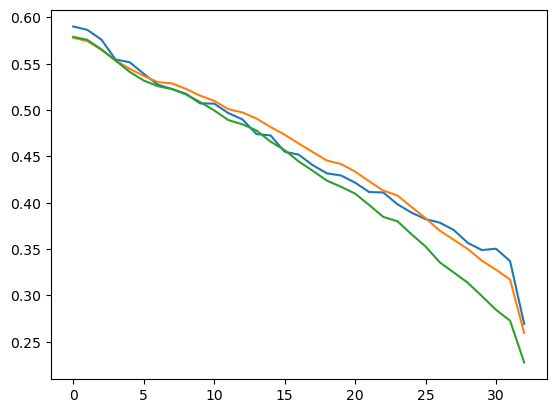

In [150]:
z1 = torch.tensor([[[-0.12839003, -0.01556321, -0.20180407, -0.1395319,   0.06569811]]])
z2 = torch.tensor([[[-0.48011202, -0.42608994, -0.8024612,  -0.2422505,  -0.01636717]]])
z3 = torch.tensor([[[-0.5861, -0.4475, -0.7799, -0.23,  -0.0227]]])
my_model = considered_model[0]
plt.plot(my_model.decoder(z1).detach().numpy().flatten())
plt.plot(my_model.decoder(z2).detach().numpy().flatten())
plt.plot(my_model.decoder(z3).detach().numpy().flatten())

In [28]:
data_filename_temp = config['preprocess']['preprocessed_data_filenamebase'] + 'train.pkl'
x_test, y_test, shots, start_times = ian_dataset(data_filename_temp,profiles,parameters,calculations,actuators,sort_by_size=True)

In [36]:
# find shot 190733 in shots
shot_index = shots.index(190733)
print(shot_index)

5023


In [85]:
def new_get_linear_x_n(model, padded_input, timesteps):
    state_dim = model.output_dim
    actuator_length = (model.input_dim - state_dim) // 2
    x_0 = padded_input[:,:-timesteps,:state_dim]
    z_n = model.encoder(x_0)
    for i in range(timesteps):
        actuators_trajectory = padded_input[:,i:-timesteps+i,state_dim+actuator_length:]
        z_n = model.A(z_n) + model.B(actuators_trajectory)
    return model.decoder(z_n)

def new_get_nonlinear_x_n(model,padded_input, timesteps):
    state_dim = model.output_dim
    actuator_length = (model.input_dim - state_dim) // 2
    x_0 = padded_input[:,:-timesteps,:state_dim]
    z_n = model.encoder(x_0)
    for i in range(timesteps):
        actuators_trajectory = padded_input[:,i:-timesteps+i,state_dim+actuator_length:]
        z_n = model.A(z_n) + model.B(actuators_trajectory)
        z_n = model.encoder(model.decoder(z_n))
    return model.decoder(z_n)

In [102]:
loss_fn=torch.nn.MSELoss(reduction='sum')
my_model = considered_model[0]
state_length = 33
good_losses = []
for shot_index in range(100):
    padded_x = x_test[shot_index].unsqueeze(0)
    good_padded_x_10_linear = my_model.new_get_linear_x_n(padded_x, 5) # CHECK THIS
    good_padded_x_10_nonlinear = my_model.new_get_nonlinear_x_n(padded_x, 5) # CHECK THIS
    future_inverting_loss = loss_fn(good_padded_x_10_linear[:,:,:state_length], good_padded_x_10_nonlinear[:,:,:state_length])
    print(future_inverting_loss)
    good_losses.append(future_inverting_loss.item())
print(good_losses)

tensor(0.0276, grad_fn=<MseLossBackward0>)
tensor(0.2109, grad_fn=<MseLossBackward0>)
tensor(0.0732, grad_fn=<MseLossBackward0>)
tensor(0.1275, grad_fn=<MseLossBackward0>)
tensor(0.0797, grad_fn=<MseLossBackward0>)
tensor(0.1329, grad_fn=<MseLossBackward0>)
tensor(0.0598, grad_fn=<MseLossBackward0>)
tensor(0.0452, grad_fn=<MseLossBackward0>)
tensor(0.0711, grad_fn=<MseLossBackward0>)
tensor(0.1657, grad_fn=<MseLossBackward0>)
tensor(0.1363, grad_fn=<MseLossBackward0>)
tensor(0.1349, grad_fn=<MseLossBackward0>)
tensor(0.0916, grad_fn=<MseLossBackward0>)
tensor(0.1221, grad_fn=<MseLossBackward0>)
tensor(0.1084, grad_fn=<MseLossBackward0>)
tensor(0.1343, grad_fn=<MseLossBackward0>)
tensor(0.1489, grad_fn=<MseLossBackward0>)
tensor(0.0797, grad_fn=<MseLossBackward0>)
tensor(0.0795, grad_fn=<MseLossBackward0>)
tensor(0.0782, grad_fn=<MseLossBackward0>)
tensor(0.0921, grad_fn=<MseLossBackward0>)
tensor(0.0936, grad_fn=<MseLossBackward0>)
tensor(0.0855, grad_fn=<MseLossBackward0>)
tensor(0.09

KeyboardInterrupt: 

In [74]:
my_model = considered_model[0]
bad_losses = []
for shot_index in range(100):
    padded_x = x_test[shot_index].unsqueeze(0)
    padded_x_10_linear = my_model.new_get_linear_x_n(padded_x, 10) # CHECK THIS
    padded_x_10_nonlinear = my_model.new_get_nonlinear_x_n(padded_x, 10) # CHECK THIS
    future_inverting_loss = loss_fn(padded_x_10_linear[:,:,:state_length], padded_x_10_nonlinear[:,:,:state_length])
    bad_losses.append(future_inverting_loss.item())
print(bad_losses)

[0.03647948056459427, 0.0885075181722641, 0.07705680280923843, 0.07732260227203369, 0.05974104255437851, 0.0645018219947815, 0.07806120812892914, 0.07229018211364746, 0.07241986691951752, 0.07828717678785324, 0.057376664131879807, 0.057270266115665436, 0.05890906974673271, 0.060991838574409485, 0.06453830748796463, 0.058180179446935654, 0.057778000831604004, 0.04713834822177887, 0.04704979807138443, 0.048306629061698914, 0.04512934759259224, 0.03945031762123108, 0.049335822463035583, 0.04217219352722168, 0.07892866432666779, 0.0745815858244896, 0.0583532452583313, 0.04627283290028572, 0.039179809391498566, 0.05811385437846184, 0.034469813108444214, 0.033968452364206314, 0.0361417680978775, 0.05533311143517494, 0.03360970690846443, 0.03393102437257767, 0.034411340951919556, 0.03649095818400383, 0.04705002158880234, 0.04844602942466736, 0.04423992335796356, 0.04353984072804451, 0.026253411546349525, 0.031068285927176476, 0.033022042363882065, 0.033774182200431824, 0.03371443971991539, 0.

HiroLRAN_nondiag(
  (ReLU): Tanh()
  (encoder): Sequential(
    (encoding_first_layer): Sequential(
      (0): Linear(in_features=33, out_features=1000, bias=True)
      (1): Tanh()
    )
    (encoding_extra_layer_0): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): Tanh()
    )
    (encoding_last_layer): Sequential(
      (0): Linear(in_features=1000, out_features=10, bias=True)
      (1): Tanh()
    )
  )
  (A): Linear(in_features=10, out_features=10, bias=False)
  (B): Linear(in_features=6, out_features=10, bias=False)
  (decoder): Sequential(
    (decoding_first_layer): Sequential(
      (0): Linear(in_features=10, out_features=1000, bias=True)
      (1): Tanh()
    )
    (decoding_extra_layer_0): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): Tanh()
    )
    (decoding_last_layer): Sequential(
      (0): Linear(in_features=1000, out_features=33, bias=True)
    )
  )
)


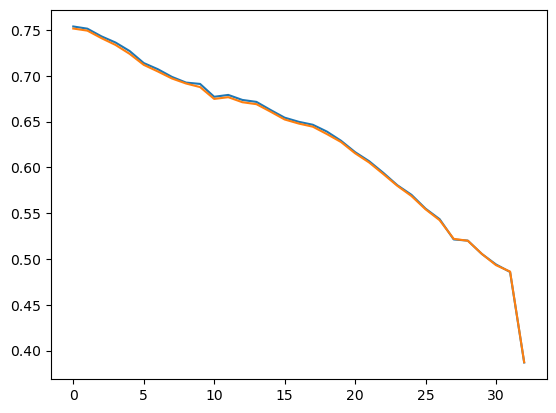

In [78]:
#plt.plot(padded_x_10_linear[0,:,20].detach().numpy())
#plt.plot(padded_x_10_nonlinear[0,:,20].detach().numpy())

padded_x = x_test[shot_index].unsqueeze(0)
padded_x_10_linear = my_model.new_get_linear_x_n(padded_x, 10)
padded_x_10_nonlinear = my_model.new_get_nonlinear_x_n(padded_x, 10)
plt.plot(padded_x_10_linear[0,50,:].detach().numpy())
plt.plot(padded_x_10_nonlinear[0,50,:].detach().numpy())


In [136]:
my_model = considered_model[0]
my_data = torch.unsqueeze(x_test[53],0)

latent_space = my_model.encoder(my_data[0,:,:33])
print(latent_space[5])
print(latent_space[100])

tensor([-0.6202, -0.2201, -0.8403, -0.0348, -0.1184],
       grad_fn=<SelectBackward0>)
tensor([-0.5861, -0.4475, -0.7799, -0.2300, -0.0227],
       grad_fn=<SelectBackward0>)


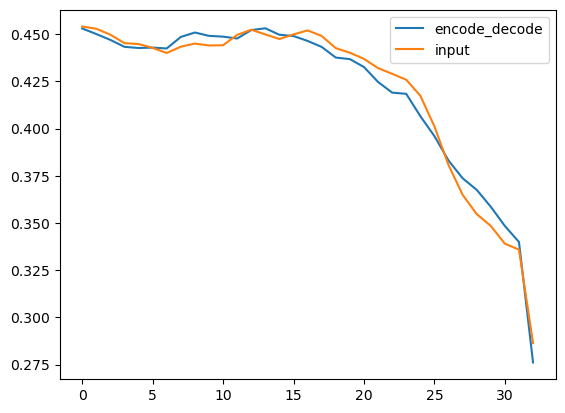

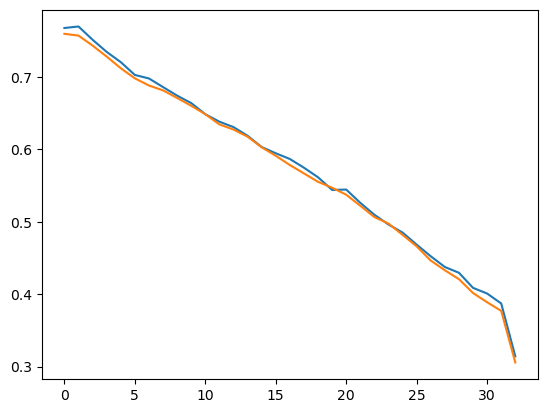

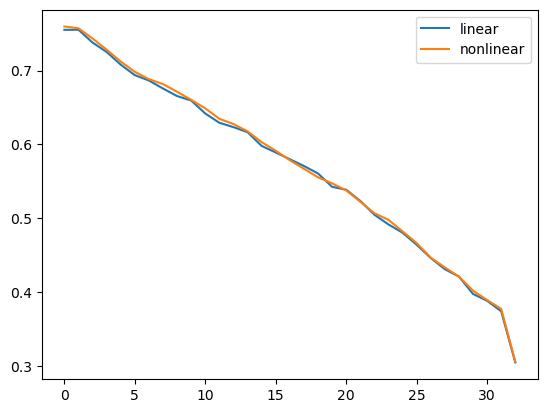

In [111]:
my_model = considered_model[0]
my_data = torch.unsqueeze(x_test[30],0)
steps = 3
timestep = 50

encode_decode = my_model.encode_decode(my_data)
plt.plot(encode_decode[0, timestep, :].detach().numpy(), label='encode_decode')
plt.plot(my_data[0, timestep, :33].detach().numpy(), label='input')
plt.legend()
plt.show()
linear_x_n = my_model.get_linear_x_n(my_data, steps)
nonlinear_x_n = my_model.get_nonlinear_x_n(my_data, steps)
nonlinear_x_n_2 = new_get_nonlinear_x_n(my_model, my_data, steps)

#plt.plot(linear_x_n[0, 50, :].detach().numpy(), label='linear')
plt.plot(nonlinear_x_n[0, 50, :].detach().numpy(), label='nonlinear')
plt.plot(nonlinear_x_n_2[0, 50, :].detach().numpy(), label='nonlinear_2')
plt.show()

linear_x_n = new_get_linear_x_n(my_model, my_data, steps)
nonlinear_x_n = new_get_nonlinear_x_n(my_model, my_data, steps)

plt.plot(linear_x_n[0, timestep, :].detach().numpy(), label='linear')
plt.plot(nonlinear_x_n[0, timestep, :].detach().numpy(), label='nonlinear')
plt.legend()
plt.show()


In [137]:
A = torch.diag(considered_model[0].A.diagonal.data)
#A = considered_model[0].A.weight
B = considered_model[0].B.weight

print(A)
print(B)

import train_helpers
print(train_helpers.get_controllability(model_type, considered_model[0]))

# check if this system is controllable
def is_controllable(A: torch.Tensor, B: torch.Tensor, tol: float = 1e-9) -> bool:
    n = A.size(0)
    C = torch.cat([torch.linalg.matrix_power(A, i) @ B for i in range(n)], dim=1)
    return torch.linalg.matrix_rank(C, tol=tol) == n
print(is_controllable(A, B))

# find eigenvalues of A
eigenvalues, eigenvectors = torch.linalg.eig(A)
print(eigenvalues)

tensor([[0.2079, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1762, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1989, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1765, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1749]])
Parameter containing:
tensor([[-0.1169,  0.1818, -0.1877,  0.0427, -0.3426,  0.0044],
        [-0.0804, -0.2486,  0.1385, -0.1563, -0.0147, -0.1770],
        [ 0.1644, -0.2195, -0.3143,  0.2126, -0.1479,  0.0303],
        [-0.1952, -0.1819, -0.1576,  0.2950, -0.1175,  0.2367],
        [-0.1196, -0.1086, -0.1067, -0.2427,  0.3759, -0.1477]],
       requires_grad=True)
tensor(0.3249, grad_fn=<AddBackward0>)
tensor(True)
tensor([0.2079+0.j, 0.1762+0.j, 0.1989+0.j, 0.1765+0.j, 0.1749+0.j])


Shot 190733
Start time 2740
Bucket 1/1 took 15s
Took 15.35 s


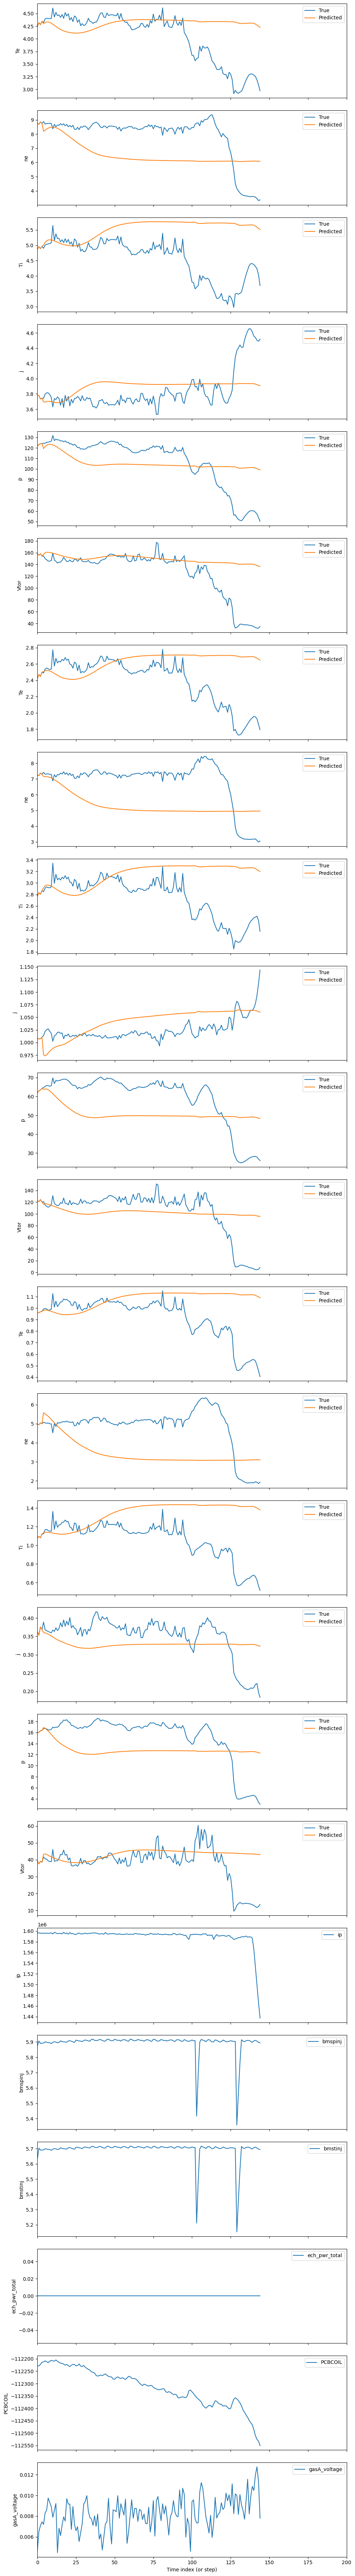

In [37]:
#shot_index = 5023

shot_index = shots.index(190733)

start_timestep = 0
print(f'Shot {shots[shot_index]}')
print(f'Start time {start_times[shot_index]}')
number_of_timesteps = -1
actuator_trajectory = get_ml_actuator_trajectory([x_test[shot_index:shot_index+1][0][start_timestep:, :]], profiles, parameters, calculations, actuators, nwarmup=nwarmup, prediction_length=prediction_length)
warmup_profiles, warmup_parameters = get_ml_profile_warmup([x_test[shot_index:shot_index+1][0][start_timestep:, :]], profiles, parameters, calculations, actuators, recorded_profiles=profiles, recorded_parameters=parameters, nwarmup=nwarmup)
true_profiles, true_params = get_ml_truth([y_test[shot_index:shot_index+1][0][start_timestep:, :]], profiles, parameters, calculations, nwarmup=nwarmup, prediction_length=-1)
predicted_profiles, predicted_params = get_ml_predictions([x_test[shot_index:shot_index+1][0][start_timestep:, :]], [y_test[shot_index:shot_index+1][0][start_timestep:, :]],
                profiles, parameters, calculations, actuators,
                considered_models=considered_model,
                recorded_profiles=profiles,
                recorded_actuators=actuators,
                recorded_parameters=parameters,
                prediction_length=-1,nwarmup=3,
                use_fancy_normalization=False,
                bucket_size=10000)
combined_true_profiles = np.concatenate((warmup_profiles, true_profiles), axis=2)
combined_predicted_profiles = np.concatenate((warmup_profiles, predicted_profiles), axis=2)
combined_true_params = np.concatenate((warmup_parameters, true_params), axis=2)
combined_predicted_params = np.concatenate((warmup_parameters, predicted_params), axis=2)
# for i, parameter in enumerate(parameters):
#     plt.plot(combined_true_params[0, i, :], label='True')
#     plt.plot(combined_predicted_params[0, i, :], label='Predicted')
#     plt.ylabel(parameter)
#     plt.legend()
#     plt.show()
# for i, profile in enumerate(profiles):
#     plt.plot(combined_true_profiles[0, i, :number_of_timesteps, 0], label='True')
#     plt.plot(combined_predicted_profiles[0, i, :number_of_timesteps, 0], label='Predicted')
#     plt.legend()
#     plt.ylabel(profile)
#     plt.ylim(bottom=0)
#     #plt.xlim((0,100))
#     plt.show()
# for i, actuator in enumerate(actuators):
#     plt.plot(actuator_trajectory[0, i, :])
#     plt.ylabel(actuator)
#     plt.ylim(bottom=0)
#     plt.show()

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1) Determine how many total subplots we need
# -----------------------------------------------------------------
n_param    = len(parameters)
n_profile  = len(profiles)
n_actuator = len(actuators)
n_subplots = n_param + n_profile*3 + n_actuator

# -----------------------------------------------------------------
# 2) Decide how many time steps for profiles/params and for actuators
# -----------------------------------------------------------------
max_t   = combined_true_profiles.shape[2]  # total time steps in profiles
plot_len = max_t if number_of_timesteps < 0 else number_of_timesteps
time     = np.arange(plot_len)

act_len  = actuator_trajectory.shape[2]    # total time steps in actuators
act_time = np.arange(act_len)

# If you want to force both to the same length:
# min_len = min(plot_len, act_len)
# time = act_time = np.arange(min_len)

# -----------------------------------------------------------------
# 3) Create figure with subplots, sharing the same x-axis
# -----------------------------------------------------------------
fig, axs = plt.subplots(n_subplots, 1, sharex=True, figsize=(10, 3*n_subplots))
axs = axs.ravel()  # ensure axs is a 1D list
subplot_idx = 0

# -----------------------------------------------------------------
# 4) Plot parameters
# -----------------------------------------------------------------
for i, param in enumerate(parameters):
    axs[subplot_idx].plot(time, combined_true_params[0, i, :plot_len], label='True')
    axs[subplot_idx].plot(time, combined_predicted_params[0, i, :plot_len], label='Predicted')
    axs[subplot_idx].set_ylabel(param)
    axs[subplot_idx].legend()
    subplot_idx += 1

# -----------------------------------------------------------------
# 5) Plot profiles (e.g. at radius index 0)
# -----------------------------------------------------------------
radius_idx = 0
for i, profile in enumerate(profiles):
    axs[subplot_idx].plot(time,
                          combined_true_profiles[0, i, :plot_len, radius_idx],
                          label='True')
    axs[subplot_idx].plot(time,
                          combined_predicted_profiles[0, i, :plot_len, radius_idx],
                          label='Predicted')
    axs[subplot_idx].set_ylabel(profile)
    axs[subplot_idx].legend()
    subplot_idx += 1

radius_idx = 15
for i, profile in enumerate(profiles):
    axs[subplot_idx].plot(time,
                          combined_true_profiles[0, i, :plot_len, radius_idx],
                          label='True')
    axs[subplot_idx].plot(time,
                          combined_predicted_profiles[0, i, :plot_len, radius_idx],
                          label='Predicted')
    axs[subplot_idx].set_ylabel(profile)
    axs[subplot_idx].legend()
    subplot_idx += 1

radius_idx = 30
for i, profile in enumerate(profiles):
    axs[subplot_idx].plot(time,
                          combined_true_profiles[0, i, :plot_len, radius_idx],
                          label='True')
    axs[subplot_idx].plot(time,
                          combined_predicted_profiles[0, i, :plot_len, radius_idx],
                          label='Predicted')
    axs[subplot_idx].set_ylabel(profile)
    axs[subplot_idx].legend()
    subplot_idx += 1

# -----------------------------------------------------------------
# 6) Plot actuators
# -----------------------------------------------------------------
for i, actuator in enumerate(actuators):
    axs[subplot_idx].plot(act_time, actuator_trajectory[0, i, :], label=actuator)
    axs[subplot_idx].set_ylabel(actuator)
    axs[subplot_idx].legend()
    subplot_idx += 1

# -----------------------------------------------------------------
# 7) Set the same x-limits for all subplots
# -----------------------------------------------------------------
# Example: from 0 to 100
x_min, x_max = 0, 200
for ax in axs:
    ax.set_xlim(x_min, x_max)

axs[-1].set_xlabel("Time index (or step)")
plt.tight_layout()
plt.show()


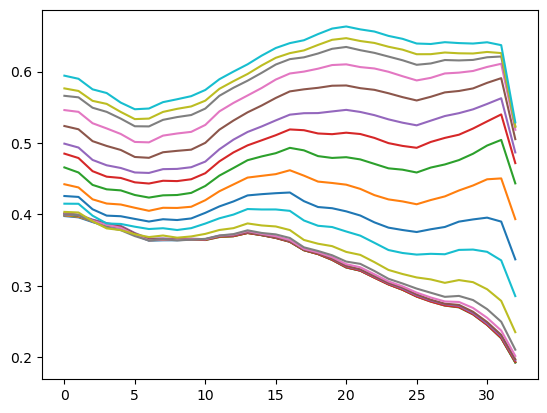

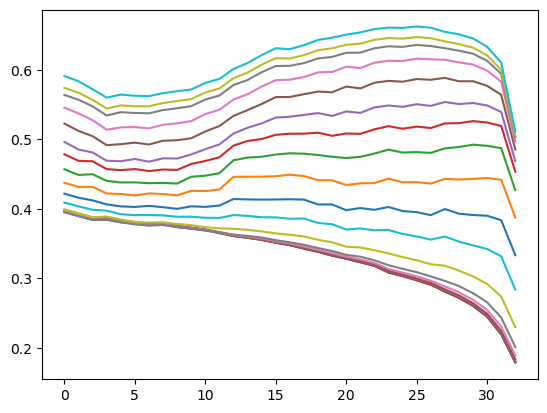

In [18]:
for i in range(20):
    plt.plot(x_test[shot_index:shot_index+1][0][start_timestep+i:start_timestep+i+1, :33][0].detach().numpy())
plt.show()
for i in range(20):
    plt.plot(considered_model[0].decoder(considered_model[0].encoder(x_test[shot_index:shot_index+1][0][start_timestep+i:start_timestep+i+1, :33].unsqueeze(0)))[0][0].detach().numpy())

In [10]:
wanted_shot = 193266
wanted_shot_idx = shots.index(wanted_shot)
print(wanted_shot_idx)
wanted_shot_indices = [i for i, shot in enumerate(shots) if shot == wanted_shot]
print(wanted_shot_indices)

ValueError: 193266 is not in list

VISUALIZE MODEL PREDICTONS

In [ ]:

with open('lran_betan_data.pkl','rb') as f:
    betan_data = pickle.load(f)
plt.plot(betan_data['pinj'],label='pinj')
plt.show()
plt.plot(betan_data['betan_lstm'],label='lstm')
plt.plot(betan_data['betan_lran'],label='lran')
plt.plot(betan_data['betan_true'],label='truth')
plt.legend()

In [38]:
with open('lran_betan_data.pkl','rb') as f:
    betan_data = pickle.load(f)

betan_data['betan_lstm'] = combined_predicted_params[0,0,:]

pickle.dump(betan_data,open('lran_betan_data.pkl','wb'))

In [24]:
profiles_data = {}
profiles_data['betan_lran'] = combined_predicted_params[0,0,:]
profiles_data['betan_true'] = combined_true_params[0, 0, :]
profiles_data['pinj'] = actuator_trajectory[0,0,:]
profiles_data['shot'] = 185365
pickle.dump(lran_data, open('lstm_profiles_data.pkl', 'wb'))

In [76]:
actuator_trajectory_lran = get_ml_actuator_trajectory(x_test[shot_index:shot_index+1], profiles, parameters, calculations, actuators, nwarmup=nwarmup, prediction_length=prediction_length)
'''for i, actuator in enumerate(actuators):
    plt.plot(actuator_trajectory[shot_index, i, :])
    plt.ylabel(actuator)
    plt.show()'''

warmup_profiles, warmup_parameters = get_ml_profile_warmup(x_test[shot_index:shot_index+1], profiles, parameters, calculations, actuators, recorded_profiles=profiles, recorded_parameters=parameters, nwarmup=nwarmup)
true_profiles, true_params = get_ml_truth(y_test[shot_index:shot_index+1], profiles, parameters, calculations, nwarmup=nwarmup, prediction_length=-1)
predicted_profiles, predicted_params = get_ml_predictions(x_test[shot_index:shot_index+1], y_test[shot_index:shot_index+1],
                profiles, parameters, calculations, actuators,
                considered_models=considered_model,
                recorded_profiles=profiles,
                recorded_actuators=actuators,
                recorded_parameters=parameters,
                prediction_length=-1,nwarmup=3,
                use_fancy_normalization=False,
                bucket_size=10000)

combined_true_profiles_lran = np.concatenate((warmup_profiles, true_profiles), axis=2)
combined_predicted_profiles_lran = np.concatenate((warmup_profiles, predicted_profiles), axis=2)
combined_true_params_lran = np.concatenate((warmup_parameters, true_params), axis=2)
combined_predicted_params_lran = np.concatenate((warmup_parameters, predicted_params), axis=2)

'''for i, actuator in enumerate(actuators):
    plt.plot(actuator_trajectory[0, i, :])
    plt.plot(actuator_trajectory[0, i, :])
    plt.ylabel(actuator)
    plt.show()
for i, parameter in enumerate(parameters):
    plt.plot(combined_true_params[0, i, :], label='True')
    plt.plot(combined_predicted_params[0, i, :], label='Predicted')
    plt.ylabel(parameter)
    plt.legend()
    plt.show()
for i, profile in enumerate(profiles):
    plt.plot(combined_true_profiles[0, i, :, 0])
    plt.plot(combined_predicted_profiles[0, i, :, 0])
    plt.ylabel(profile)
    plt.show()'''


Bucket 1/1 took 0s
Took 0.10 s


"for i, actuator in enumerate(actuators):\n    plt.plot(actuator_trajectory[0, i, :])\n    plt.plot(actuator_trajectory[0, i, :])\n    plt.ylabel(actuator)\n    plt.show()\nfor i, parameter in enumerate(parameters):\n    plt.plot(combined_true_params[0, i, :], label='True')\n    plt.plot(combined_predicted_params[0, i, :], label='Predicted')\n    plt.ylabel(parameter)\n    plt.legend()\n    plt.show()\nfor i, profile in enumerate(profiles):\n    plt.plot(combined_true_profiles[0, i, :, 0])\n    plt.plot(combined_predicted_profiles[0, i, :, 0])\n    plt.ylabel(profile)\n    plt.show()"

In [77]:
actuator_trajectory_lran = np.delete(actuator_trajectory, 3, axis=1)

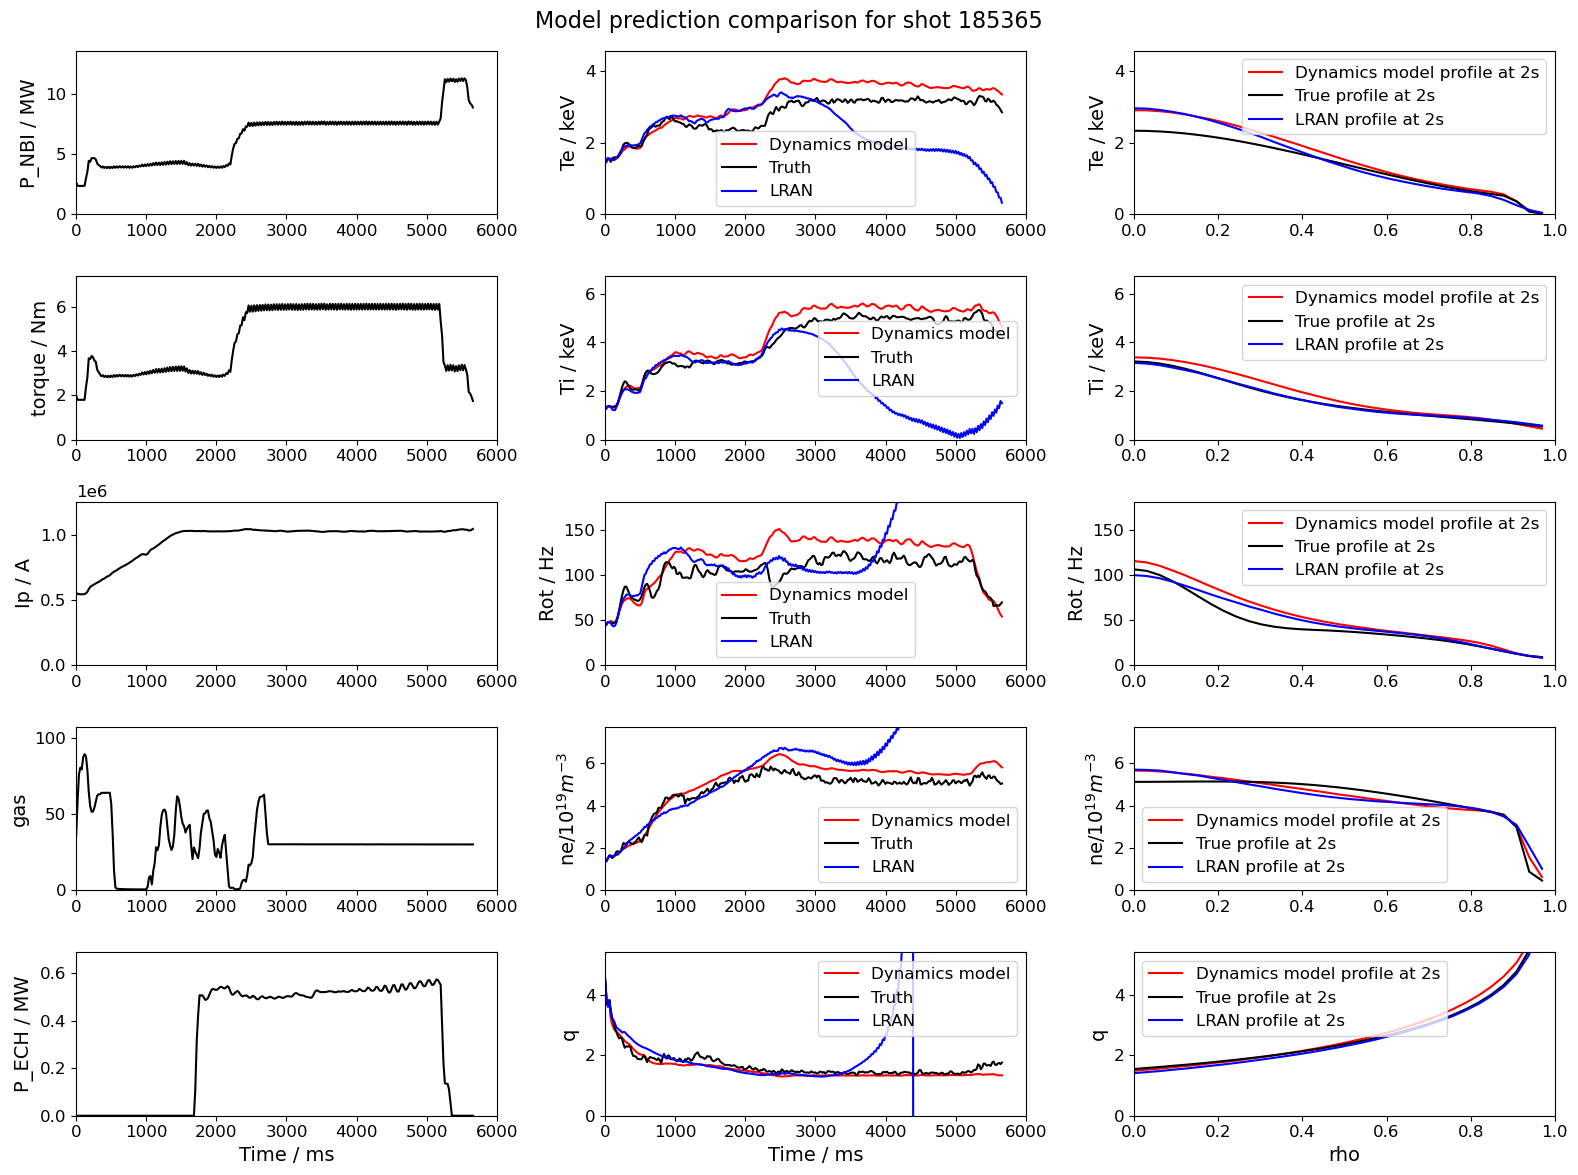

In [88]:
rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
actuator_labels = ['P_NBI / MW', 'torque / Nm', 'Ip / A','gas', 'P_ECH / MW']
timetrace = actuator_trajectory[0, 0, :]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1], axes[:,2]], axis=0)

# Set subplot limits and labels
for i, ax in enumerate(axes):
    if i < len(actuator_labels):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.nanmax(actuator_trajectory[0,i,:])*1.2/1000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, actuator_trajectory[0,i,:]/1000, color='black')

        elif actuator_labels[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.nanmax(actuator_trajectory[0,i,:])*1.2/1000000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, actuator_trajectory[0,i,:]/1000000, color='black')
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.nanmax(actuator_trajectory[0,i,:])*1.2)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, actuator_trajectory[0,i,:], color='black')
    elif i < len(actuator_labels) + len(profile_labels):
        ax.set_xlim(0, 20*len(timetrace))
        ax.set_ylim(0, np.nanmax(combined_predicted_profiles[0,i-len(actuator_labels),:, 0])*1.2)
        ax.set_ylabel(profile_labels[i-len(actuator_labels)])
        ax.plot(np.arange(3+len(timetrace[:]))*20, combined_predicted_profiles[0,i-len(actuator_labels),:, 0], label='Dynamics model', color='red')
        ax.plot(np.arange(3+len(timetrace[:]))*20, combined_true_profiles[0,i-len(actuator_labels),:, 0], label='Truth', color='black')
        ax.plot(np.arange(3+len(timetrace[:]))*20, combined_predicted_profiles_lran[0,i-len(actuator_labels),:, 0], label='LRAN', color='blue')
        ax.legend()
    elif i < len(actuator_labels) + 2*len(profile_labels):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, np.nanmax(combined_predicted_profiles[0,i-len(profile_labels) - len(actuator_labels),:, 0])*1.2)
        ax.set_ylabel(profile_labels[i-len(profile_labels) - len(actuator_labels)])
        ax.plot(rhos, combined_predicted_profiles[0,i-len(profile_labels) - len(actuator_labels),100, :], label='Dynamics model profile at 2s', color='red')
        ax.plot(rhos, combined_true_profiles[0,i-len(profile_labels) - len(actuator_labels),100, :], label='True profile at 2s', color='black')
        ax.plot(rhos, combined_predicted_profiles_lran[0,i-len(profile_labels) - len(actuator_labels),100, :], label='LRAN profile at 2s', color='blue')
        ax.legend()
axes[4].set_xlabel('Time / ms')
axes[9].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')
fig.suptitle('Model prediction comparison for shot 185365')
plt.tight_layout()
plt.savefig('185365_shot_performance.svg')

PLOTS FROM ROLLOUT

In [19]:
with open('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/test_rollout_alldiiid_ensemble.pkl', 'rb') as f:
    data = pickle.load(f)
with open('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/rollout_alldiiid_ensemble.pkl', 'rb') as f:
    data2 = pickle.load(f)

In [20]:
directory = '/projects/EKOLEMEN/profile_predictor/joe_hiro_models/'

with open(f'{directory}rollout_{model_name}.pkl', 'rb') as f:
    all_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/projects/EKOLEMEN/profile_predictor/joe_hiro_models/rollout_HiroLRAN_etemp5.pkl'

In [21]:
ensemble_model_predictions_list = []
for i in range(4):
    with open(f'{directory}rollout_alldiiid_ensemble{i}_RESUMED.pkl', 'rb') as f:
        all_data = pickle.load(f)
        ensemble_model_predictions_list.append(all_data[list(all_data.keys())[index]])


NameError: name 'index' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q', r'$Z_{eff}$']
actuator_labels = ['P_NBI / MW', 'torque / Nm', 'Ip / A','Bt / T','gas', 'P_ECH / MW', 'Triangularity bot', 'Triangularity top', r'$\kappa$', 'a minor / m', r'Volume $m^3$', 'R major / m']
timetrace = data['truth']['actuators'][actuators[0]]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1], axes[:,2]], axis=0)
# Initialize line objects for each subplot
predictions = [ax.plot([], [], lw=2, label='Predictions')[0] for ax in axes]
targets = [ax.plot([], [], lw=2, label='Truth')[0] for ax in axes]
ensemble_1 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
ensemble_2 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
ensemble_3 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
ensemble_4 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
# Set subplot limits and labels
for i, ax in enumerate(axes):
    if i < len(actuators):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000, alpha=0.3)
        elif actuator_labels[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000000, alpha=0.3)
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]], alpha=0.3)
    else:
        ax.set_xlim(0, 1)
        if i -len(actuators) < len(profiles):
            ax.set_ylim(0, np.max(data['truth']['profiles'][profiles[i-len(actuators)]][:])*1.2)
            ax.set_ylabel(profile_labels[i-len(actuators)])
        ax.legend()
axes[5].set_xlabel('Time / ms')
axes[11].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')

def animate(time):
    for i in range(len(axes)):
        if i < len(actuators):
            if actuator_labels[i] == 'P_NBI / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time]/1000)
            else:
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time])
            #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0][:])
        else:
            
            predictions[i].set_data(rhos, np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[i-len(actuators)]][0][time] for j in range(4)]), axis=0))
            
            targets[i].set_data(rhos, data['truth']['profiles'][profiles[i-len(actuators)]][time])
            ensemble_1[i].set_data(rhos, ensemble_model_predictions_list[0]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            ensemble_2[i].set_data(rhos, ensemble_model_predictions_list[1]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            ensemble_3[i].set_data(rhos, ensemble_model_predictions_list[2]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            ensemble_4[i].set_data(rhos, ensemble_model_predictions_list[3]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
    return predictions + targets
fig.suptitle('Simulation of shot 185885', fontsize=16)
ani = animation.FuncAnimation(fig, animate, frames=len(timetrace), interval=50, blit=True)
ani.save(f'{model_name}{index}.mp4', writer='ffmpeg')
HTML(ani.to_html5_video())

In [49]:

full_arrs = np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[15-len(actuators)]][0] for j in range(4)])
print(np.mean(full_arrs, axis=-1).shape)
#print(np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[15-len(actuators)]][0][:, :] for j in range(4)]), axis=0))

(4, 271)


In [6]:
fig, axes = plt.subplots(nrows=len(data['truth']['actuators'].keys())+len(data['truth']['parameters'].keys())+len(data['truth']['profiles'].keys()), ncols=1, figsize=(8, 20), sharex=True)
actuator_labels = ['P_NBI / W', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / W']
#profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
#parameter_labels = ['betaN']
actuator_labels = list(data['truth']['actuators'].keys())
profile_labels = list(data['truth']['profiles'].keys())
parameter_labels = list(data['truth']['parameters'].keys())
time = np.arange(len(data['truth']['actuators'][actuators[0]]))*20

for i, ax in enumerate(axes):
    if i < len(actuators):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.plot(time, data['truth']['actuators'][actuators[i]]/1000)
            ax.set_ylabel(f'{actuator_labels[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
        else:
            ax.plot(time, data['truth']['actuators'][actuators[i]])
            ax.set_ylabel(f'{actuator_labels[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
    elif i < len(actuators) + len(parameters):
        ax.plot(time[:], data['predictions']['parameters'][parameters[i-len(actuators)]][0], label='predicted')
        ax.plot(time, data['truth']['parameters'][parameters[i-len(actuators)]], label='truth')
        ax.set_ylabel(f'{parameter_labels[i-len(actuators)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
    else:

        #predicted_mean = np.mean(data['predictions']['profiles'][profiles[i - len(actuators) - len(parameters)]][0], axis=1)
        predicted_mean = np.mean(np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[i-len(actuators)]][0] for j in range(4)]), axis=-1), axis=0)
        predicted_std = np.std(np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[i-len(actuators)]][0] for j in range(4)]), axis=-1), axis=0)
        truth_mean = np.mean(data['truth']['profiles'][profiles[i - len(actuators) - len(parameters)]], axis=1)
        ax.plot(time, predicted_mean, label='predicted')
        ax.plot(time, truth_mean, label='truth')
        ax.set_ylabel(f'{profile_labels[i-len(actuators)-len(parameters)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
        #ax.set_ylim(bottom=0)

# Set the x-axis label for the bottom subplot
axes[-1].set_xlabel('Time / ms')
axes[len(actuators)].legend()
axes[0].set_title('Actuators')
axes[len(actuators)].set_title('Predicted Profiles')
plt.subplots_adjust(hspace=0.1)
#plt.savefig(f'{model_name}{index}.png')
# Display the plot
plt.show()

NameError: name 'data' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
actuator_labels = ['P_NBI / MW', 'torque / Nm', 'Ip / A','Bt / T','gas', 'P_ECH / MW', 'Triangularity bot', 'Triangularity top', r'$\kappa$', 'a minor / m', r'Volume $m^3$', 'R major / m']
timetrace = data['truth']['actuators'][actuators[0]]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1], axes[:,2]], axis=0)[:-1]
# Initialize line objects for each subplot
predictions = [ax.plot([], [], lw=2, label='Predictions')[0] for ax in axes]
targets = [ax.plot([], [], lw=2, label='Truth')[0] for ax in axes]

# Set subplot limits and labels
for i, ax in enumerate(axes):
    if i < len(actuators):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000, alpha=0.2)
        elif actuator_labels[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000000, alpha=0.2)
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]], alpha=0.2)
    else:
        ax.set_xlim(0, 1)
        if i -len(actuators) < len(profiles):
            ax.set_ylim(0, np.max(data['truth']['profiles'][profiles[i-len(actuators)]][:])*1.2)
            ax.set_ylabel(profile_labels[i-len(actuators)])
        ax.legend()
axes[len(actuators)].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')

def animate(time):
    for i in range(len(axes)):
        if i < len(actuators):
            if actuator_labels[i] == 'P_NBI / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time]/1000)
            else:
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time])
            #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0][:])
        else:
            predictions[i].set_data(rhos, data['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            targets[i].set_data(rhos, data['truth']['profiles'][profiles[i-len(actuators)]][time])
    return predictions + targets

ani = animation.FuncAnimation(fig, animate, frames=6, interval=150, blit=True)
ani.save(f'{model_name}{index}.mp4', writer='ffmpeg')
HTML(ani.to_html5_video())